In [20]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# 1. Data Collection

In [21]:
import pandas as pd
import json

data_path = "C:/Users/PanSt/Desktop/4ML/Sarcasm-Detection-using-NLP/sarcasm dataset/Sarcasm_Headlines_Dataset.json"

data = []
with open(data_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

data = pd.DataFrame(data).iloc[:,1:]
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26709 non-null  object
 1   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.5+ KB


In [23]:
data.duplicated().value_counts()

False    26602
True       107
Name: count, dtype: int64

## Error prevention

Use ```.reset_index()``` method to avoid the following error when training which is caused by the the indec of the dataframe not having continuous values:

```python

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File c:\Users\PanSt\Desktop\4ML\Sarcasm-Detection-using-NLP\.venv\Lib\site-packages\pandas\core\indexes\base.py:3805, in Index.get_loc(self, key)
   3804 try:
-> 3805     return self._engine.get_loc(casted_key)
   3806 except KeyError as err:

File index.pyx:167, in pandas._libs.index.IndexEngine.get_loc()

File index.pyx:196, in pandas._libs.index.IndexEngine.get_loc()

File pandas\\_libs\\hashtable_class_helper.pxi:2606, in pandas._libs.hashtable.Int64HashTable.get_item()

File pandas\\_libs\\hashtable_class_helper.pxi:2630, in pandas._libs.hashtable.Int64HashTable.get_item()

KeyError: 4605

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent call last)
Cell In[36], line 7
      4 for epoch in range(num_epochs):
      5     print(f'Epoch {epoch+1}/{num_epochs}')
----> 7     train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
      8     valid_loss, valid_acc = evaluate(model, test_loader, loss_fn)
...
   3815     #  InvalidIndexError. Otherwise we fall through and re-raise
   3816     #  the TypeError.
   3817     self._check_indexing_error(key)

KeyError: 4605
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
```

In [24]:
data = data.drop_duplicates().reset_index() # use reset_index() to prevent KeyError when training
data.duplicated().value_counts()

False    26602
Name: count, dtype: int64

# 2. Tokenization and data Pipeline

In [25]:
%pip install torchtext

Note: you may need to restart the kernel to use updated packages.


In [26]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.headline = dataframe.headline
        self.targets = self.data.is_sarcastic
        self.max_len = max_len

    def __len__(self):
        return len(self.headline)

    def __getitem__(self, index):
        headline = str(self.headline[index])
        headline = " ".join(headline.split())

        inputs = self.tokenizer.encode_plus(
            headline,
            truncation='do_not_truncate',
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids='pt'
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [27]:
import torch, torchaudio, torchvision
print(torch.__version__)
print(torchvision.__version__)
print(torchaudio.__version__)

2.3.0+cu121
0.18.0+cu121
2.3.0+cu121


In [28]:
train_size = int(0.80 * data.shape[0])
train_df, test_df = data.iloc[:train_size,:], data.iloc[train_size:,:].reset_index()

batch_size = 11
train_loader, test_loader = DataLoader(CustomDataset(train_df, tokenizer, 200), batch_size=batch_size, shuffle=True), DataLoader(CustomDataset(test_df, tokenizer, 200), batch_size=batch_size, shuffle=False)
#train_dataset, test_dataset = CustomDataset(train_df, tokenizer, 200), CustomDataset(test_df, tokenizer, 200)

In [29]:
#%pip install transformers

In [5]:
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# 3. Modelling

In [6]:
from transformers import BertModel

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1) # (768, 1) for bert-base, (1024, 1) for bert-large
    
    def forward(self, ids, mask, token_type_ids):
        hidden, output_1 = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [32]:
optimizer = torch.optim.Adam(params = model.parameters(), lr=1e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [33]:
from tqdm.auto import tqdm

In [34]:
def train(model, train_loader, optimizer, criterion):
  correct = 0
  epoch_loss = 0
  total_samples = 0
  model.train()
  pbar = tqdm(train_loader, total=len(train_loader))

  for i, data in enumerate(pbar):  # Use the pbar directly here
    if data['ids'].dim() == 2: # check if the dimension of the inputs is 2. If so, no unsqeezing is needed
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    elif data['ids'].dim() == 1: # if the values are 1D then add a first dimension: [1, max_len] -> [1, max_len], this will happen when batch_size = 1. Pytorch will return values as 1D
      ids = data['ids'].to(device, dtype = torch.long).unsqueeze(0)
      mask = data['mask'].to(device, dtype = torch.long).unsqueeze(0)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long).unsqueeze(0)
    targets = data['targets'].to(device, dtype = torch.float) # targets remain 1D

    optimizer.zero_grad()
    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids).squeeze()
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    y_pred = (outputs > 0).type(torch.long)
    correct += (y_pred == targets).sum().item()
    total_samples += targets.size(0)
    accuracy = correct / total_samples

    pbar.set_postfix(ordered_dict={
      'batch': f"{int(i + 1)}/{len(train_loader)}",
      'train_accuracy': f"{accuracy * 100:.2f}%",
      'train_loss': f"{epoch_loss*train_loader.batch_size/total_samples:.4f}"
    }, refresh=True)
  pbar.close()
  return epoch_loss / len(train_loader), accuracy

In [35]:
def evaluate(model, test_loader, criterion):
  correct = 0
  epoch_loss = 0
  total_samples = 0
  model.eval()
  pbar = tqdm(test_loader, total=len(test_loader))

  with torch.no_grad():
    for i, data in enumerate(pbar):
      if data['ids'].dim() == 2: # check if the dimension of the inputs is 2. If so, no unsqeezing is needed
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      elif data['ids'].dim() == 1: # if the values are 1D then add a first dimension: [1, max_len] -> [1, max_len], this will happen when batch_size = 1. Pytorch will return values as 1D
        ids = data['ids'].to(device, dtype = torch.long).unsqueeze(0)
        mask = data['mask'].to(device, dtype = torch.long).unsqueeze(0)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long).unsqueeze(0)
      targets = data['targets'].to(device, dtype = torch.float) # targets remain 1D

      outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids).squeeze()
      loss = criterion(outputs, targets)
      
      epoch_loss += loss.item()
      y_pred = (outputs > 0).type(torch.long)
      correct += (y_pred == targets).sum().item()
      total_samples += targets.size(0)
      accuracy = correct / total_samples

      pbar.set_postfix(ordered_dict={
        'batch': f"{int(i + 1)}/{len(test_loader)}",
        'valid_accuracy': f"{accuracy * 100:.2f}%",
        'valid_loss': f"{epoch_loss*test_loader.batch_size/total_samples:.4f}"
      }, refresh=True)
  pbar.close()
  return epoch_loss / len(test_loader), accuracy

In [36]:
num_epochs = 25
history = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')

    train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
    valid_loss, valid_acc = evaluate(model, test_loader, loss_fn)

    history.append([train_loss, valid_loss, train_acc, valid_acc])

    if train_acc > 0.99:
      print('\n More than 99.0% accuracy reached --> terminating training')
      break

Epoch 1/25


  0%|          | 0/1935 [00:00<?, ?it/s]

c:\Users\PanSt\Desktop\4ML\Sarcasm-Detection-using-NLP\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


KeyboardInterrupt: 

Save progress done

In [ ]:
# Save the model state
torch.save(model.state_dict(), 'bert_cased_sarcasm.pth')

In [7]:
import torch
# Load the model
torch.cuda.empty_cache()
model = BERTClass()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load('bert_cased_sarcasm.pth'))
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

# 4. Model Evaluation

In [ ]:
history_df = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
history_df.to_csv('model_history.csv', index=False)
history_df

,train_loss,valid_loss,train_acc,valid_acc
0,0.270605,0.185764,0.885344,0.923135
1,0.116928,0.185911,0.956816,0.931780
2,0.051968,0.284476,0.982332,0.919564
3,0.028164,0.305330,0.990085,0.917121


C:\Users\PanSt\AppData\Local\Temp\ipykernel_55488\135128056.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


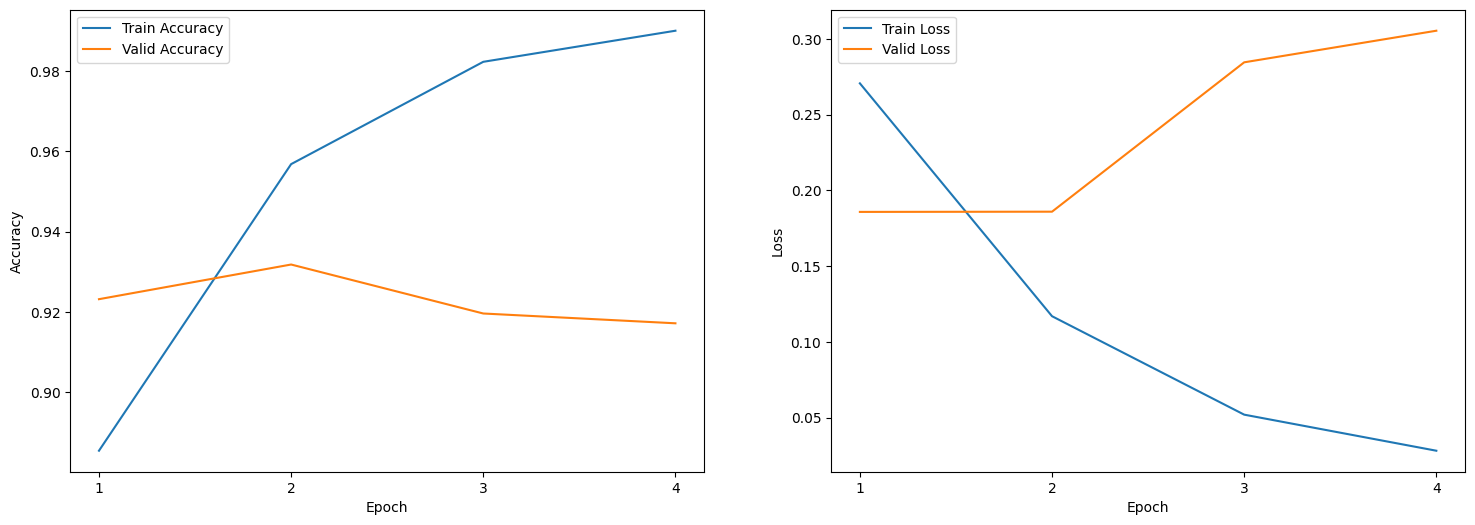

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(np.arange(1, history_df.shape[0]+1), history_df['train_acc'], label='Train Accuracy')
ax1.plot(np.arange(1, history_df.shape[0]+1), history_df['valid_acc'], label='Valid Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(np.arange(1,history_df.shape[0]+1,1))
ax1.legend()

ax2.plot(np.arange(1, history_df.shape[0]+1), history_df['train_loss'], label='Train Loss')
ax2.plot(np.arange(1, history_df.shape[0]+1), history_df['valid_loss'], label='Valid Loss')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_xticks(np.arange(1,history_df.shape[0]+1,1))
ax2.legend()

fig.show()

# 5. Classify Custom Headline

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [12]:
def process_input_from_keyboard():
    input_sentence = input("Please enter a headline: ")

    print(f'Headline: {input_sentence}')
    
    def label_mapping(index):
        return 'sarcastic' if index == 1 else 'literal'

    input_sentence = " ".join(input_sentence.split())
    inputs = tokenizer.encode_plus(
        input_sentence,
        truncation='do_not_truncate',
        add_special_tokens=True,
        max_length=None,
        return_token_type_ids='pt'
    )

    if torch.tensor(inputs['input_ids'], dtype=torch.long).dim() == 2:
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long)
    elif torch.tensor(inputs['input_ids'], dtype=torch.long).dim() == 1:
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0)
        token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).unsqueeze(0)

    ids, mask, token_type_ids = ids.to(device, dtype=torch.long), mask.to(device, dtype=torch.long), token_type_ids.to(device, dtype=torch.long)

    with torch.no_grad():
        outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids).squeeze()
        y_pred = (outputs > 0).type(torch.long)
        confidence = torch.sigmoid(torch.abs(outputs)).item()*100

    predicted_label = label_mapping(y_pred)
    print(f'This headline is {predicted_label}. ({confidence:.2f}% confidence)')

process_input_from_keyboard()

Headline: Absolutely Shocking: Local Man Discovers Water is Wet, Scientists Baffled
This headline is sarcastic. (90.52% confidence)
